In [1]:
!pip install --quiet -r https://raw.githubusercontent.com/JoaquinLCalvo/Explained-CNN-SSL/refs/heads/explainability/requirements.txt

Requested lightning-bolts from https://files.pythonhosted.org/packages/b7/73/b992893803a7d7ec8afe465f98d5b2808de22da11f3770d6094e08393aee/lightning_bolts-0.6.0.post1-py3-none-any.whl (from -r https://raw.githubusercontent.com/JoaquinLCalvo/Explained-CNN-SSL/refs/heads/explainability/requirements.txt (line 4)) has invalid metadata: .* suffix can only be used with `==` or `!=` operators
    torchvision (>=0.10.*) ; extra == 'dev'
                 ~~~~~~~^
Please use pip<24.1 if you need to use this version.
Requested lightning-bolts from https://files.pythonhosted.org/packages/05/5d/08864c691b9d2731adcb157bcf26de69bfaab5fce70853380c37ca884a42/lightning_bolts-0.6.0-py3-none-any.whl (from -r https://raw.githubusercontent.com/JoaquinLCalvo/Explained-CNN-SSL/refs/heads/explainability/requirements.txt (line 4)) has invalid metadata: .* suffix can only be used with `==` or `!=` operators
    torchvision (>=0.10.*) ; extra == 'dev'
                 ~~~~~~~^
Please use pip<24.1 if you need to us

In [2]:
#Standard libraries
import os
from copy import deepcopy
from tqdm.notebook import tqdm

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#PyTorch
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

#Torchvision
import torchvision
import torchvision.transforms.functional as FT
from torchvision import transforms
from torchvision.datasets import STL10

#PyTorch Lightning
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger

#Explainability
from captum.attr import IntegratedGradients

#Wandb
import wandb

# Setting the seed
pl.seed_everything(47)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Path configurations
DATASET_PATH = "data/"
NUM_WORKERS = os.cpu_count()

# Device configs
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

Seed set to 47


Device: cpu
Number of workers: 4


In [ ]:
## Wandb Initialization

wandb.init(
    project="Explained-CNN-SimCLR",
    config={
        "backbone": "Resnet50",
        "epochs": 5,
        "batch_size": 256,
        "learning_rate": 1e-3,
        "temperature": 0.07,
        "hidden_dim": 128
    }
)

wandb: WARNING Path /wandb/ wasn't writable, using system temp directory.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING Path /wandb/ wasn't writable, using system temp directory
wandb: Currently logged in as: joaquinlcalvo (Explained-SimCLR). Use `wandb login --relogin` to force relogin


In [4]:
## Data Preparation

# To prepare the data loading we need to sample two different, random augmentations for each image in the batch.
# For this, we create a transformation that, when being called, applies a set of data augmentations to an image twice

class ContrastiveTransformations(object):

    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]

In [5]:
# Data augmentations for SimCLR
contrast_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=96),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)
    ], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=9),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [6]:
# Datasets for contrastive learning
unlabeled_data = STL10(
    root=DATASET_PATH,
    split="unlabeled",
    download=True,
    transform=ContrastiveTransformations(contrast_transforms, n_views=2)
    )

train_data_contrast = STL10(
    root=DATASET_PATH,
    split="train",
    download=True,
    transform=ContrastiveTransformations(contrast_transforms, n_views=2)
)

PermissionError: [Errno 13] Permission denied: 'data/'

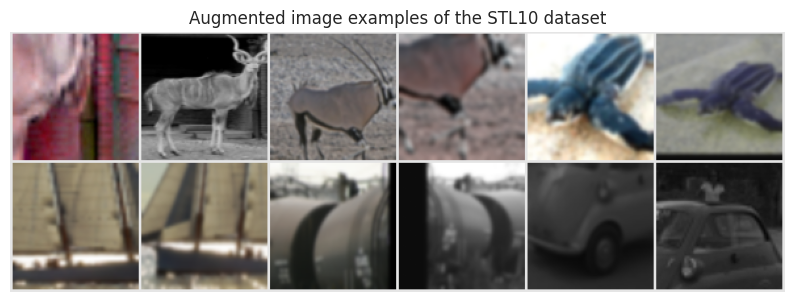

In [ ]:
# Visualize examples

NUM_IMAGES = 6
imgs = torch.stack([img for idx in range(NUM_IMAGES) for img in unlabeled_data[idx][0]], dim=0)
img_grid = torchvision.utils.make_grid(imgs, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(10,5))
plt.title('Augmented image examples of the STL10 dataset')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [ ]:
## SimCLR model definition

class SimCLR(pl.LightningModule):

    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'
        # Base model f(.)
        self.convnet = torchvision.models.resnet50(num_classes=4*hidden_dim)  # Output of last linear layer
        # The MLP for g(.) consists of Linear->ReLU->Linear
        self.convnet.fc = nn.Sequential(
            self.convnet.fc,  # Linear(ResNet output, 4*hidden_dim)
            nn.ReLU(inplace=True),
            nn.Linear(4*hidden_dim, hidden_dim)
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                            T_max=self.hparams.max_epochs,
                                                            eta_min=self.hparams.lr/50)
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, batch, mode='train'):
        imgs, _ = batch
        imgs = torch.cat(imgs, dim=0)

        # Encode all images
        feats = self.convnet(imgs)
        # Calculate cosine similarity
        cos_sim = F.cosine_similarity(feats[:,None,:], feats[None,:,:], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        self.log(mode+'_loss', nll)
        wandb.log({f"{mode}_loss": nll.item()})  # wandb logging
        
        # Get ranking position of positive example
        comb_sim = torch.cat([cos_sim[pos_mask][:,None],  # First position positive example
                              cos_sim.masked_fill(pos_mask, -9e15)],
                             dim=-1)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        self.log(mode+'_acc_top1', (sim_argsort == 0).float().mean())
        self.log(mode+'_acc_top5', (sim_argsort < 5).float().mean())
        self.log(mode+'_acc_mean_pos', 1+sim_argsort.float().mean())

        wandb.log({
            f"{mode}_acc_top1": top1_acc.item(),
            f"{mode}_acc_top5": top5_acc.item(),
            f"{mode}_acc_mean_pos": mean_pos_acc.item()
        })

        return nll

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode='val')

In [ ]:
## Train SimCLR Model

def train_simclr(batch_size=256, max_epochs=500, **kwargs):
    
    # Initialize the trainer
    trainer = pl.Trainer(
        accelerator="gpu" if str(device).startswith("cuda") else "cpu",
        devices=1,
        max_epochs=max_epochs,
        callbacks=[
            LearningRateMonitor(logging_interval='epoch')
        ]
    )

    trainer.logger._default_hp_metric = None

    # Create data loaders
    train_loader = DataLoader(
        unlabeled_data,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        pin_memory=True,
        num_workers=NUM_WORKERS
    )
    val_loader = DataLoader(
        train_data_contrast,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
        pin_memory=True,
        num_workers=NUM_WORKERS
    )

    # Seed for reproducibility
    pl.seed_everything(47)

    # Initialize the SimCLR model
    model = SimCLR(max_epochs=max_epochs, **kwargs)

    # Train the model
    trainer.fit(model, train_loader, val_loader)

    return model


In [ ]:
# In contrastive learning: The larger the batch size, the better the performance.
# A larger batch size allows us to compare each image to more negative examples,
# this leads to overall smoother loss gradients.

In [ ]:
# Train the SimCLR model
simclr_model = train_simclr(hidden_dim=128,
                            lr=1e-3,
                            temperature=0.07,
                            weight_decay=1e-4,
                            max_epochs=10)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:lightning_fabric.utilities.seed:Seed set to 47
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type   | Params | Mode 
-------------------------------------------
0 | convnet | ResNet | 24.6 M | train
-------------------------------------------
24.6 M    Trainable params
0         Non-trainable params
24.6 M    Total params
98.491    Total estimated model params size (MB)
154       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [ ]:
# Downstream Classifier.

# INTERNAL NOTES:
# After training the SimCLR CNN (encoder + projection head),
# we perform Logistic Regression on the features. That is:
# We learn a single, linear layer that maps the representation to a class prediction.
# Since the base network ( f(.) ) isn't changed during the training process, the model can only perform well
# if the representation of h describe all features that might be necessary for the task.

# So, below, we implement a Logistic Regression for which we assume that the images
# have been encoded in their feature vectors

class LogisticRegression(pl.LightningModule):

    def __init__(self, feature_dim, num_classes, lr, weight_decay, max_epochs=100):
        super().__init__()
        self.save_hyperparameters()
        # Mapping from representation h to classes
        self.model = nn.Linear(feature_dim, num_classes)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                                      milestones=[int(self.hparams.max_epochs*0.6),
                                                                  int(self.hparams.max_epochs*0.8)],
                                                      gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode='train'):
        feats, labels = batch
        preds = self.model(feats)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(mode + '_loss', loss)
        self.log(mode + '_acc', acc)
        return loss

    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='val')

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='test')

In [ ]:
# The training contains 500 images per class, while the test set has 800 images per class.

img_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5,), (0.5,))])

train_img_data = STL10(root=DATASET_PATH, split='train', download=True,
                       transform=img_transforms)
test_img_data = STL10(root=DATASET_PATH, split='test', download=True,
                      transform=img_transforms)

print("Number of training examples:", len(train_img_data))
print("Number of test examples:", len(test_img_data))

In [ ]:
# The function below creates a feature dataset by passing the original dataset (e.g., STL-10) through the SimCLR encoder
# This process generates fixed feature vectors (1D) for each image.

#  the encoder is modified to output features directly by replacing the projection head
# (g(.)) with an identity layer (nn.Identity).

# The extracted features are stored as a new TensorDataset

@torch.no_grad()
def prepare_data_features(model, dataset):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    data_loader = DataLoader(dataset, batch_size=64, num_workers=NUM_WORKERS, shuffle=False, drop_last=False)
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(data_loader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)

    # Sort images by labels
    labels, idxs = labels.sort()
    feats = feats[idxs]

    return TensorDataset(feats, labels)

In [ ]:
# Apply previous function to training and test sets.

train_feats_simclr = prepare_data_features(simclr_model, train_img_data)
test_feats_simclr = prepare_data_features(simclr_model, test_img_data)

In [ ]:
# Training function
def train_logreg(batch_size, train_feats_data, test_feats_data, max_epochs=100, **kwargs):
    # Initialize wandb logger
    wandb_logger = WandbLogger(project="Explained-CNN-SimCLR")
    
    # Define the Trainer
    trainer = pl.Trainer(
        accelerator="gpu" if str(device).startswith("cuda") else "cpu",
        devices=1,
        max_epochs=max_epochs,
        logger=wandb_logger,
        callbacks=[LearningRateMonitor("epoch")],
        enable_progress_bar=True,
        check_val_every_n_epoch=1
    )
    trainer.logger._default_hp_metric = None  # Disable default metric tracking

    # Data loaders
    train_loader = DataLoader(
        train_feats_data, batch_size=batch_size, shuffle=True,
        drop_last=False, pin_memory=True, num_workers=0
    )
    test_loader = DataLoader(
        test_feats_data, batch_size=batch_size, shuffle=False,
        drop_last=False, pin_memory=True, num_workers=0
    )

    # Define LogisticRegression model
    class LogisticRegressionWithLogging(LogisticRegression):
        def training_step(self, batch, batch_idx):
            feats, labels = batch
            preds = self.model(feats)
            loss = F.cross_entropy(preds, labels)
            acc = (preds.argmax(dim=-1) == labels).float().mean()

            # Log training accuracy and loss
            self.log("train_loss", loss, prog_bar=True, on_epoch=True)
            self.log("train_accuracy", acc, prog_bar=True, on_epoch=True)
            wandb.log({"epoch_train_accuracy": acc})
            return loss

        def validation_step(self, batch, batch_idx):
            feats, labels = batch
            preds = self.model(feats)
            loss = F.cross_entropy(preds, labels)
            acc = (preds.argmax(dim=-1) == labels).float().mean()

            # Log validation accuracy
            self.log("val_loss", loss, prog_bar=True, on_epoch=True)
            self.log("val_accuracy", acc, prog_bar=True, on_epoch=True)
            wandb.log({"epoch_test_accuracy": acc})
            return loss

    # Instantiate the model
    model = LogisticRegressionWithLogging(**kwargs)

    # Train the model and log epoch-wise metrics
    trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=test_loader)

    # Test the model for final accuracy results
    train_result = trainer.test(model, train_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)

    # Log final train and test accuracy to wandb
    wandb.log({
        "final_train_accuracy": train_result[0]["test_acc"],
        "final_test_accuracy": test_result[0]["test_acc"]
    })
    
    # Finish wandb run
    wandb.finish()

    return model, {"train_accuracy": train_result[0]["test_acc"], "test_accuracy": test_result[0]["test_acc"]}


In [ ]:
# Train and evaluate
results = {}

# Train logistic regression with the full training dataset
logreg_model, full_set_results = train_logreg(
    batch_size=64,
    train_feats_data=train_feats_simclr,  # Full training dataset
    test_feats_data=test_feats_simclr,   # Full test dataset
    #model_suffix="full_dataset",
    feature_dim=train_feats_simclr.tensors[0].shape[1],  # Feature size from SimCLR
    num_classes=10,  # Number of classes
    lr=1e-3,
    weight_decay=1e-3
)

# Store the results
results["full_dataset"] = full_set_results


In [ ]:
# Print results
print(f"Train accuracy: {results['full_dataset']['train_accuracy'] * 100:.2f}%")
print(f"Test accuracy: {results['full_dataset']['test_accuracy'] * 100:.2f}%")

In [ ]:
## Save the model
# Path to save the model on Colab
simclr_model_save_path = "simclr_model.pth"

# Save the model's state_dict
torch.save(logreg_model.state_dict(), simclr_model_save_path)
print(f"Model saved to {simclr_model_save_path}")

# Download the model to your local machine
from google.colab import files
files.download(simclr_model_save_path)

#Log model artifacts to wandb
wandb.save(simclr_model_save_path)
wandb.log({"simclr_model": wandb.Artifact("simclr_model", type="model")})

In [ ]:
SAVED_MODELS_PATH = "saved_models"

simclr_model_path = os.path.join(SAVED_MODELS_PATH, "simclr_model.pth")
simclr_model = SimCLR()
simclr_model.load_state_dict(torch.load(simclr_model_path, weights_only=True))
simclr_model.eval()

mlp_model_path = os.path.join(SAVED_MODELS_PATH, "mlp_model.pth")
mlp_model = MLPClassifier()
mlp_model.load_state_dict(torch.load(mlp_model_path, weights_only=True))
mlp_model.eval()

EXAMPLES_FOLDER = "examples"
EXAMPLE_NUMBER = "2"
examples_image_folder_path = os.path.join(EXAMPLES_FOLDER, EXAMPLE_NUMBER)
os.makedirs(examples_image_folder_path, exist_ok=True)

EXAMPLE_IMAGE_NAME = "attributions.png"
examples_image_path = os.path.join(examples_image_folder_path, EXAMPLE_IMAGE_NAME)

EXAMPLES_COUNT = 5
class_names = ["airplane", "bird", "car", "cat", "deer", "dog", "horse", "monkey", "ship", "truck"]
models = {
    'clr': simclr_model,
    'mlp': mlp_model
}

In [ ]:
# Getting some example images from the dataset
def get_examples(size=EXAMPLES_COUNT):
    examples = []
    for i in range(size):
        image, label = test_data[i]
        examples.append({
            'img': image,
            'label': label
        })
    return examples

In [ ]:
def get_attributions(model, examples: list):

    def forward_fn(inputs):
        if inputs.dim() == 3:
            inputs = inputs.unsqueeze(0)
        return model(inputs, classify=True)
    ig = IntegratedGradients(forward_fn)

    results = []
    for example in examples:
        input_tensor = example['img']
        input_tensor = input_tensor.unsqueeze(0)

        with torch.no_grad():
            logits = model(input_tensor, classify=True)
            target_class = logits.argmax(dim=-1).item()

        attributions, delta = ig.attribute(
            inputs=input_tensor, target=target_class, return_convergence_delta=True
        )
        attributions_np = attributions[0].cpu().detach().numpy()
        attributions_np = (attributions_np - attributions_np.min()) / (attributions_np.max() - attributions_np.min())
        results.append({
            'prediction': target_class,
            'attr': attributions_np.transpose(1, 2, 0)
        })
    return results

In [ ]:
def show_attributions(attributions, model_names, save_fig=False):
    if not isinstance(attributions, list):
        attributions = [attributions]
    fig, ax = plt.subplots(len(attributions), 3, figsize=(10, 5 * len(attributions)))
    for idx, ex in enumerate(attributions):
        img = ex['img']
        label = ex['label']

        img = img.detach()
        img = FT.to_pil_image(img)

        ax[idx, 0].imshow(np.asarray(img))
        ax[idx, 0].set_title(f'Original image class is {class_names[label]}')

        for jdx, model_name in enumerate(model_names):
            prediction = ex[model_name]['prediction']
            attr = ex[model_name]['attr']
            ax[idx, jdx + 1].imshow(attr)
            ax[idx, jdx + 1].set_title(f'Attributions of {model_name} (predicted: {class_names[prediction]})')
    plt.tight_layout()
    if save_fig:
        plt.savefig(examples_image_path)
    plt.show()

In [ ]:
examples = get_examples()
models_attributions = {}
for model_name in models:
    models_attributions[model_name] = get_attributions(model=models[model_name], examples=examples)
    for idx in range(len(examples)):
        examples[idx][model_name] = {}
        examples[idx][model_name]['prediction'] = models_attributions[model_name][idx]['prediction']
        examples[idx][model_name]['attr'] = models_attributions[model_name][idx]['attr']

In [ ]:
show_attributions(attributions=examples, model_names=models.keys(), save_fig=True)